# Trading at the Close - Hyperparameter Optimization
-----------------------
-----------------------


This notebook is intended to be run after the preprocessing notebook. In here,  However, the XGBoost model does not provide a good objective for the mean absolute error. LGBM does a better job in this regard. Therefore, we'll use the LGBMRegressor and Optuna to find good hyperparameters.

We'll also use `loguru` for colored logging :)

## Installs
-------------

In [1]:
%pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
import numpy as np
from pathlib import Path
from loguru import logger
from pprint import pformat
import pandas as pd
import json
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer
from IPython.display import clear_output
import optuna
from optuna.samplers import TPESampler, CmaEsSampler
from optuna.pruners import MedianPruner, HyperbandPruner
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate,
)

optuna.logging.set_verbosity(optuna.logging.WARNING)
sns.set_style("ticks")

c:\Users\salva\OneDrive\Documentos\Python Projects\trading-at-the-close\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
class CFG:
    JOBS_PATH = Path(".", "job_artifacts")
    JOB_NAME = "optiver-tuning_lgbmregressor"
    TRAINING_PATH = Path(".", "train_files", "train.csv")
    FEATURES_PATH = JOBS_PATH.joinpath("optiver-feature_selection-0002")
    FEATURES_NAME = "feature_names.json"
    BEST_PARAMS = "best_params.json"
    RANDOM_STATE = 123
    USE_GPU = False
    MODEL = LGBMRegressor
    CROSSVAL = TimeSeriesSplit
    SAMPLER = CmaEsSampler
    PRUNER = HyperbandPruner
    USE_BEST = True
    JOB_PATH_BEST = JOBS_PATH.joinpath("optiver-tuning_lgbmregressor-0006")
    HYPERTUNE = True
    PRELOAD_STUDY = False
    N_FOLDS = 5
    N_TRIALS = 200
    N_JOBS = 4

In [4]:
def lgbm_param_space(trial):
    """Returns the parameter space of a LGBMRegressor."""
    # num_leaves should be smaller than 2^{max_depth}
    max_depth = trial.suggest_int("max_depth", 5, 12)
    num_leaves = trial.suggest_int("num_leaves", 20, int((2**max_depth) * 0.75))

    param_space = {
        "device": trial.suggest_categorical("device", ["gpu" if CFG.USE_GPU else "cpu"]),
        "verbose": trial.suggest_categorical("verbose", [-1]),
        "n_jobs": trial.suggest_categorical("n_jobs", [1]),
        #"random_state": trial.suggest_categorical("random_state", [CFG.RANDOM_STATE]),
        "objective": trial.suggest_categorical("objective", ["mae"]),
        "n_estimators": trial.suggest_categorical("n_estimators", [750]), # automatically via early stopping
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt"]),
        "min_child_samples": trial.suggest_int("min_child_samples", 400, 2000),
        "subsample": trial.suggest_float("subsample", 0.4, 1.0),
        "subsample_freq": trial.suggest_categorical("subsample_freq", [0, 1]),
        "subsample_for_bin": trial.suggest_int("subsample_for_bin", 100000, 600000),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        #"reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 2.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 5e-1, 3.0, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.12, log=False),
        "num_leaves": num_leaves,
        "max_depth": max_depth,
        "min_split_gain": trial.suggest_float("min_split_gain", 0, 3),
    }

    return param_space



def lgbm_callbacks(trial):
    """Returns the callbacks for a LGBMRegressor."""
    optuna_prune = optuna.integration.LightGBMPruningCallback(trial, "l1", report_interval=100)
    inner_early_stop = lgb.early_stopping(25, verbose=False)

    return [inner_early_stop]
    #return [optuna_prune, inner_early_stop]


MODEL_CFG = {
    LGBMRegressor.__name__ : {
        "param_space": lgbm_param_space,
        "callbacks": lgbm_callbacks
    }
}  

In [5]:
CFG.JOBS_PATH.mkdir(exist_ok=True, parents=True)

for i in range(1, 10000):
    CFG.JOB_PATH = CFG.JOBS_PATH.joinpath(CFG.JOB_NAME + "-" +  str(i).zfill(4))
    try:
        CFG.JOB_PATH.mkdir()
        break
    except:
        continue

## Data Loading
---------------

In the next cell, I define code to load the data and to generate features with optional memory reduction. I write these two functions in a file called `preprocess.py` with the cell magi `%%writefile`, so that I can import it with `from preprocess import load_data`. With this, my other notebooks can do the same thing without having to redefine these functions. In case I make changes, all notebooks automatically use the same updated version.

In [6]:
from utils.featurizers import featurize
from utils.files import read_json

df = pd.read_csv(CFG.TRAINING_PATH)
selected_features = read_json(CFG.FEATURES_PATH.joinpath(CFG.FEATURES_NAME))["selected_features"]

# Get features
featurize(df, selected_features)

# Clean entries with no predictive value
df.dropna(subset="target", inplace=True)

# Separate features from dependent variable
Y = df["target"]
X = df.drop(columns=["target"])

del df

2023-10-12 15:00:00.402 | INFO     | utils.featurizers:featurize:16 - Creating additional features...
2023-10-12 15:00:46.440 | INFO     | utils.featurizers:featurize:64 - Dropping unnecesary features...
2023-10-12 15:00:46.845 | INFO     | utils.featurizers:featurize:68 - Reducing data memory footprint...
2023-10-12 15:00:46.845 | INFO     | utils.compression:downcast:11 - Memory usage of dataframe is 639.40 MB
2023-10-12 15:00:50.096 | INFO     | utils.compression:downcast:20 - Memory usage after optimization is: 394.63 MB
2023-10-12 15:00:50.096 | INFO     | utils.compression:downcast:22 - Decreased by 38.28%


# Hyperparameter Optimization

## Setup the evaluation process

We have two options:
1. Use a simple train-test split for evaluation
2. Use a Cross-Validation with TimeSeriesSplit for more robust evaluation

The second option is much more expensive to tune, but it yields more robust estimations of mean absolute error.
We define functions for both and then try them out!

### Evaluation via Cross Validation with TimeSeriesSplit

In [7]:
def cross_validate(model, x, y, cv=TimeSeriesSplit(), scorer=mean_absolute_error, callbacks=None):
    scores = np.zeros(cv.n_splits)
    
    logger.info(f"Starting evaluation...")
    logger.info("=" * 30)
    for i, (train_index, val_index) in enumerate(cv.split(x)):
        
        x_train, x_val = x.iloc[train_index], x.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        start = timer()
        model.fit(x_train, y_train, eval_set=[(x_val, y_val)], callbacks=callbacks)
        end = timer()
        
        y_pred = model.predict(x_val)
        scores[i] = scorer(y_pred, y_val)
        logger.info(f"Fold {i + 1}: {scores[i]:.4f} (took {end - start:.2f}s)")
        
    logger.info("-" * 30)
    logger.success(f"Average MAE = {scores.mean():.4f} ± {scores.std():.2f}")
    logger.info("=" * 30)
    
    return scores

## Optimization specifics

We define a convenience function `run_optimization`, that starts the optimization process with sane defaults, given a objective function.

The objective function is returned by the `get_objective_function` method, which configures the logging and evaluation process ("simple" or "cross_validate").
Inside this method, the parameter space is defined using the optuna `trial` object.

In [18]:
# Optimization runner
def run_optimization(objective, n_trials=100, sampler=TPESampler(), pruner=MedianPruner(), n_jobs=1, best_trial=None):
    """Run the given objective with Optuna and return the study results."""

    study_name = "optuna-study"
    storage = "sqlite:///" + str(CFG.JOB_PATH.joinpath(study_name)) + ".sqlite3"
    logger.info(f"Creating study...")


    if CFG.PRELOAD_STUDY:
        study = optuna.load_study(
            study_name=study_name, 
            direction="minimize", 
            sampler=sampler,
            pruner=pruner,
            storage=storage
        )

    else:
        try:
            optuna.study.delete_study(
                study_name=study_name,
                storage=storage
            )
        except:
            logger.warning(f"Study does not exist...")

        study = optuna.create_study(
            study_name=study_name, 
            direction="minimize", 
            sampler=sampler,
            pruner=pruner,
            storage=storage
        )

        if best_trial is not None:
            logger.info("Enqueuing previous best trial ...")
            study.enqueue_trial(best_trial)

        logger.info(f"Running hyperparameter search...")
        study.optimize(objective, n_trials=n_trials, n_jobs=n_jobs, show_progress_bar=True)

    logger.info(f"Number of finished trials: {len(study.trials)}")
    logger.success(f"Best MAE: {study.best_value:.4f}")

    logger.info("Parameters: ")
    logger.info("=" * 10)
    logger.success(pformat(study.best_params, indent=4))

    logger.info(f"Saving best parameters...")
    with open("best_params.json", "w") as f:
        json.dump(study.best_params, f)
    return study

In [9]:
def get_objective_function(model_cls, param_func, x, y, cv=TimeSeriesSplit(), callbacks_func=None):
    """Returns the objective function for optuna."""
        
    def objective_function(trial):
        """Optimizes a model with cross-validation."""

        param_space = param_func(trial)
        callbacks = callbacks_func(trial) if callbacks_func is not None else None
        model = model_cls(**param_space)    
        scores = cross_validate(model, x, y, cv=cv, callbacks=callbacks)
        return scores.mean()

    return objective_function

### Start the optimization

We can set these variables here:
1. `run_lgbm_optimization`: Whether to run the optimization or use already computed ones.
2. `n_trials`: How many trials we want to sample.
3. `logging_level`: Configures the logging level inside evaluation functions (use either `'info'` or `'success'`)
4. `evaluation`: Use either 'simple' for simple train-test split or 'cross_validate' for cross validation using TimeSeriesSplit.
5. `cv`: the Split object
6. `reuse_best_trial`: whether to reuse a previously tuned best trial for this optimization

*Warning*: `evaluation='cross_validate'` takes very long!

In [19]:
from utils.files import read_json

if CFG.USE_BEST:
    best_params = read_json(CFG.JOB_PATH_BEST.joinpath(CFG.BEST_PARAMS))

In [22]:
from utils.files import dump_json

model_cls = CFG.MODEL
model_cfg = MODEL_CFG[CFG.MODEL.__name__]
param_space_func = model_cfg["param_space"]
callbacks_func = model_cfg["callbacks"]
best_trial = best_params if CFG.USE_BEST else None

clear_output(wait=True) # clears output before rerunning optimization

if CFG.HYPERTUNE:
    objective = get_objective_function(model_cls, param_space_func, X, Y, cv=TimeSeriesSplit(n_splits=CFG.N_FOLDS), callbacks_func=callbacks_func)
    study = run_optimization(objective, sampler=CFG.SAMPLER(), pruner=CFG.PRUNER(), n_trials=CFG.N_TRIALS, n_jobs=CFG.N_JOBS, best_trial=best_trial)
    best_params = study.best_params
    dump_json(CFG.JOB_PATH.joinpath(CFG.BEST_PARAMS), best_params, indent=4)

2023-10-12 16:26:42.865 | INFO     | __main__:run_optimization:7 - Creating study...
2023-10-12 16:26:43.846 | INFO     | __main__:run_optimization:37 - Enqueuing previous best trial ...
2023-10-12 16:26:43.865 | INFO     | __main__:run_optimization:40 - Running hyperparameter search...
  0%|          | 0/200 [00:00<?, ?it/s]2023-10-12 16:26:44.396 | INFO     | __main__:cross_validate:4 - Starting evaluation...
2023-10-12 16:26:44.399 | INFO     | __main__:cross_validate:5 - ==============================
2023-10-12 16:26:44.985 | INFO     | __main__:cross_validate:4 - Starting evaluation...
2023-10-12 16:26:44.985 | INFO     | __main__:cross_validate:5 - ==============================
2023-10-12 16:26:45.363 | INFO     | __main__:cross_validate:4 - Starting evaluation...
2023-10-12 16:26:45.363 | INFO     | __main__:cross_validate:5 - ==============================
2023-10-12 16:26:45.394 | INFO     | __main__:cross_validate:4 - Starting evaluation...
2023-10-12 16:26:45.401 | INFO   

[W 2023-10-12 16:54:58,227] Trial 87 failed with parameters: {'max_depth': 12, 'num_leaves': 896, 'device': 'cpu', 'verbose': -1, 'n_jobs': 1, 'random_state': 123, 'objective': 'mae', 'n_estimators': 750, 'boosting_type': 'gbdt', 'min_child_samples': 498, 'subsample': 0.8095290373019706, 'subsample_freq': 1, 'subsample_for_bin': 458379, 'colsample_bytree': 0.8039463346794586, 'reg_lambda': 1.2626537255042092, 'learning_rate': 0.10190031386305712, 'min_split_gain': 0.10500313986542953} because of the following error: MemoryError((3491928, 16), dtype('float64')).
Traceback (most recent call last):
  File "c:\Users\salva\OneDrive\Documentos\Python Projects\trading-at-the-close\.venv\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\salva\AppData\Local\Temp\ipykernel_20240\1671290876.py", line 10, in objective_function
    scores = cross_validate(model, x, y, cv=cv, callbacks=callbacks)
  File "C:\Users\salva\AppData\Lo

2023-10-12 16:55:36.641 | INFO     | __main__:cross_validate:17 - Fold 4: 6.3278 (took 49.78s)
2023-10-12 16:55:46.693 | INFO     | __main__:cross_validate:17 - Fold 4: 6.3249 (took 53.03s)
2023-10-12 16:55:57.185 | INFO     | __main__:cross_validate:17 - Fold 3: 6.0993 (took 52.70s)
c:\Users\salva\OneDrive\Documentos\Python Projects\trading-at-the-close\.venv\lib\site-packages\optuna\trial\_trial.py:494: UserWarning:

The reported value is ignored because this `step` 99 is already reported.

2023-10-12 16:56:44.749 | INFO     | __main__:cross_validate:17 - Fold 5: 5.8856 (took 62.54s)
2023-10-12 16:56:44.750 | INFO     | __main__:cross_validate:19 - ------------------------------
2023-10-12 16:56:44.751 | SUCCESS  | __main__:cross_validate:20 - Average MAE = 6.4762 ± 0.50
2023-10-12 16:56:44.751 | INFO     | __main__:cross_validate:21 - ==============================
Best trial: 0. Best value: 6.4697:  42%|████▏     | 84/200 [30:00<2:17:18, 71.02s/it]2023-10-12 16:56:57.164 | INFO    

MemoryError: Unable to allocate 426. MiB for an array with shape (3491928, 16) and data type float64

### Ploting Hyperparameter Tuning Results

In [12]:
if CFG.HYPERTUNE:
    plot_optimization_history(study).show()
    if CFG.N_TRIALS > 1:
        plot_param_importances(study).show()
        plot_parallel_coordinate(study, params=["max_depth", "num_leaves", "learning_rate", "min_split_gain", "min_child_samples"]).show()

## Reevaluation and training
--------------------

### Validating the tuned parameters with cross validation

In [24]:
model = LGBMRegressor(**best_params)
model.set_params(n_jobs=CFG.N_JOBS)
scores = cross_validate(
    model=model,
    x=X,
    y=Y,
    scorer=mean_absolute_error,
    cv=TimeSeriesSplit(n_splits=CFG.N_FOLDS)
)

2023-10-12 17:06:48.778 | INFO     | __main__:cross_validate:4 - Starting evaluation...
2023-10-12 17:06:48.780 | INFO     | __main__:cross_validate:5 - ==============================
2023-10-12 17:09:50.497 | INFO     | __main__:cross_validate:17 - Fold 1: 7.3059 (took 96.47s)
2023-10-12 17:14:09.967 | INFO     | __main__:cross_validate:17 - Fold 2: 6.7743 (took 164.78s)
2023-10-12 17:19:14.518 | INFO     | __main__:cross_validate:17 - Fold 3: 6.1135 (took 218.22s)
2023-10-12 17:25:22.779 | INFO     | __main__:cross_validate:17 - Fold 4: 6.3527 (took 279.22s)
2023-10-12 17:32:40.077 | INFO     | __main__:cross_validate:17 - Fold 5: 5.8963 (took 349.13s)
2023-10-12 17:32:40.077 | INFO     | __main__:cross_validate:19 - ------------------------------
2023-10-12 17:32:40.077 | SUCCESS  | __main__:cross_validate:20 - Average MAE = 6.4885 ± 0.50
2023-10-12 17:32:40.077 | INFO     | __main__:cross_validate:21 - ==============================


### Retrain model on three different random states


In [38]:
from utils.files import save_model

val_size = 0.1

rng = np.random.default_rng()
seeds = rng.integers(low=0, high=1000, size=5)
for i, seed in enumerate(seeds):
    logger.info(f"Fitting model {i} with seed={seed}")

    model = LGBMRegressor(**best_params)
    model.set_params(random_state=seed)

    # Train directly with all the data
    if val_size < 0.01:
        model.fit(X, Y)

    # Strip the last part for validation
    else:
        X_train, X_val, y_train, y_val = train_test_split(X, Y, shuffle=False, test_size=0.1)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(25)])
        y_pred = model.predict(X_val, num_iteration=model.best_iteration_)
        score = mean_absolute_error(y_val, y_pred)
    
    model_path = CFG.JOB_PATH.joinpath("models")
    model_path.mkdir(exist_ok=True, parents=True)
    save_model(model, file=model_path.joinpath("model-" + str(i + 1).zfill(2) + ".pkl"))

2023-10-12 17:57:11.945 | INFO     | __main__:<module>:8 - Fitting model 0 with seed=397


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[263]	valid_0's l1: 5.86304


2023-10-12 18:00:15.464 | INFO     | __main__:<module>:8 - Fitting model 1 with seed=420


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[306]	valid_0's l1: 5.8643


2023-10-12 18:03:49.055 | INFO     | __main__:<module>:8 - Fitting model 2 with seed=682


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[252]	valid_0's l1: 5.86356


2023-10-12 18:06:50.731 | INFO     | __main__:<module>:8 - Fitting model 3 with seed=107


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[228]	valid_0's l1: 5.86465


2023-10-12 18:09:30.361 | INFO     | __main__:<module>:8 - Fitting model 4 with seed=640


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[289]	valid_0's l1: 5.86413


<Axes: >

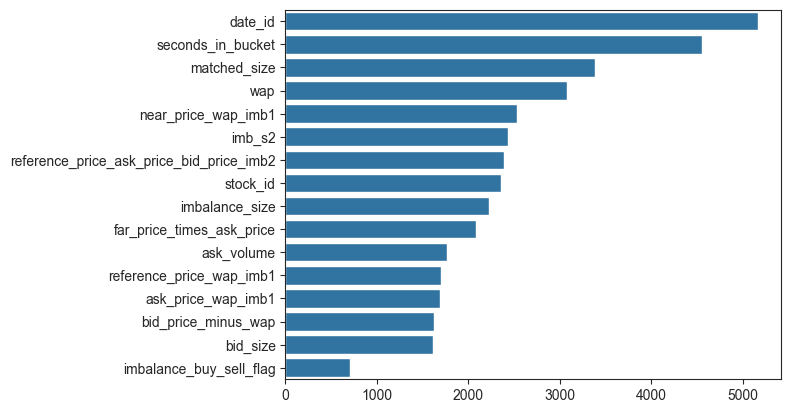

In [39]:
idx = np.argsort(model.feature_importances_)[::-1]
sns.barplot(x=model.feature_importances_[idx], y=np.array(model.feature_name_)[idx], orient="horizontal")